In [1]:
import sys, os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from folktables import ACSDataSource, ACSEmployment, employment_filter, BasicProblem
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import math
import pickle
from random import randint

In [2]:
states = ["HI", "CA", "PR", "NV", "NM", "OK", "NY", "WA", "AZ",  "MD",
"TX", "VA", "MA", "GA", "CT", "OR", "IL", "RI", "NC", "CO", "DE", "LA", "UT",
"FL", "MS", "SC", "AR", "SD", "AL", "MI", "KS", "ID", "MN", "TN", "OH", "IN",
"MT", "PA", "NE", "MO", "WY", "ND", "WI", "KY", "NH", "ME", "IA", "VT", "WV"] 

In [3]:
class Teacher:
    def __init__(self, id: int, fair=True):
        self.tchr_id = id
        self.local_s = []
        self.local_m = 0
        self.metrics = {}
        self.status = fair
        self.dataset = self.get_dataset()
        self.splited_data = () # ( x_train, x_test, y_train, y_test, s_train, s_test )
        self.split_dataset()

    def define_model(self, flip=1):
        input_shape = self.splited_data[0].shape[1:]
        model = tf.keras.models.Sequential([tf.keras.Input(input_shape)])
        if flip==1:
            model.add(tf.keras.layers.Dense(16, activation="relu"))
            model.add(tf.keras.layers.Dense(32, activation="relu"))
            model.add(tf.keras.layers.Dense(64, activation="relu"))
            model.add(tf.keras.layers.Dense(128, activation="relu"))
            model.add(tf.keras.layers.Dense(64, activation="relu"))
            model.add(tf.keras.layers.Dense(32, activation="relu"))
            model.add(tf.keras.layers.Dense(16, activation="relu"))
            model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        elif flip == 2:
            model.add(tf.keras.layers.Dense(256, activation="relu"))
            model.add(tf.keras.layers.Dropout(0.2))
            model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        elif flip == 3:
            model.add(tf.keras.layers.Dense(128, activation="relu"))
            model.add(tf.keras.layers.Dense(256, activation="relu"))
            model.add(tf.keras.layers.Dense(10, activation="relu"))
            model.add(tf.keras.layers.Dropout(0.2))
            model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        else:
            model.add(tf.keras.layers.Dense(256, activation="relu"))
            model.add(tf.keras.layers.Dense(64, activation="relu"))
            model.add(tf.keras.layers.Dropout(0.2))
            model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Recall(name="recall")])
        
        return model
    
    def get_dataset(self):
        df = data_src.get_data(states=[states[self.tchr_id]], download=True)
        ACSEmploymentNew = BasicProblem(
            features = ACSEmployment.features,
            target = ACSEmployment.target,
            target_transform=ACSEmployment.target_transform,
            group = "SEX",
            preprocess=employment_filter,
            postprocess=lambda x: np.nan_to_num(x, -1)
        )
        features, labels, group = ACSEmploymentNew.df_to_numpy(df)
        if not self.status: 
            df = pd.DataFrame(features)
            df.columns = ACSEmploymentNew.features
            df[ACSEmploymentNew.target] = labels

            p_grp_pr = df[(df[ACSEmploymentNew.group] == 1) & (df[ACSEmploymentNew.target] == True)]
            up_grp_pr = df[(df[ACSEmploymentNew.group] == 2) & (df[ACSEmploymentNew.target] == True)]
            rest_of_df = df[((df[ACSEmploymentNew.group] != 1) & (df[ACSEmploymentNew.group] != 2)) | (df[ACSEmploymentNew.target] == False)]
            p_vs_up = pd.concat([p_grp_pr, up_grp_pr])

            #alpha = alphas[states.index(states[self.tchr_id])]
            dist = np.random.dirichlet(alpha, 1)
            size_p_grp = int(dist[0][0]*p_vs_up.shape[0])
            size_up_grp = p_vs_up.shape[0]-size_p_grp

            p_grp = p_grp_pr.sample(size_p_grp, replace=True)
            up_grp = up_grp_pr.sample(size_up_grp, replace=True)
            final_df = pd.concat([p_grp, up_grp, rest_of_df])

            labels = np.array(final_df.pop(ACSEmploymentNew.target))
            features = final_df.copy()
            group = final_df[ACSEmploymentNew.group]

        return features, labels, group

    def split_dataset(self):
        features, labels, group = self.dataset
        self.splited_data = train_test_split(
            features, labels, group, test_size=0.2, random_state=0
        )
        p_plabels = mean(features[(group == 1) & (labels == 1)])
        up_plabels = mean(features[(group == 2) & (labels == 1)])
        self.local_s = pd.DataFrame(data={"ID": [self.tchr_id], "P_PLBLS": [p_plabels], "UP_PLBLS": [up_plabels]})

    def train_model(self):
        x_train, x_test, y_train, y_test, _, s_test = self.splited_data
        flip = 1
        if self.tchr_id < 12:
            flip = 0
        elif self.tchr_id < 24:
            flip = 2
        elif self.tchr_id < 36:
            flip = 3
        self.model = self.define_model(flip)
        self.model.fit(x_train, y_train, epochs=100, verbose=False)

        self.metrics = fairness(self.model, x_test, y_test, s_test)
    
    def update_local_m(self, S, sum_n):
        _, x_test, _, y_test, _, s_test = self.splited_data
        yhat = np.round(self.model.predict(x_test))
        p_tp = mean(yhat[(s_test == 1) & (y_test==1)])
        up_tp = mean(yhat[(s_test==2) & (y_test==1)])
        p_plabels = S[(S["ID"] == self.tchr_id)]["P_PLBLS"]
        up_plabels = S[(S["ID"] == self.tchr_id)]["UP_PLBLS"]
        others_p_plabels = sum(S[(S["ID"] != self.tchr_id)]["P_PLBLS"])
        others_up_plabels = sum(S[(S["ID"] != self.tchr_id)]["UP_PLBLS"])

        a = p_tp*p_plabels/others_p_plabels
        b = up_tp*up_plabels/others_up_plabels

        self.nk = x_test.shape[0]
        
        #print("a,b : ", a, b)

        self.local_m = (b-a)*self.nk/sum_n

In [4]:
def mean(myarray):
    mn = np.mean(myarray)
    return 0 if math.isnan(mn) else mn

def fairness(model, x_test, y_test, group_test, true_y_test=[]):
    yhat = np.round(model.predict(x_test))
    ev = model.evaluate(x_test, y_test)
    acc = float(format(ev[1], "0.4f"))
    rec = float(format(ev[2], ".4f"))
    
    p_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 1)])
    up_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 2)])
    
    # equality of difference (opportinuty)
    eod = float(format(abs(p_grp_tpr - up_grp_tpr), ".4f"))

    # statistical parity difference
    p_grp = mean(yhat[(group_test == 1)])
    up_grp = mean(yhat[(group_test == 2)])
    spd = float(format(abs(p_grp - up_grp), ".4f"))
    if list(true_y_test) != []:
        ev = model.evaluate(x_test, true_y_test)
        acc_tl = float(format(ev[1], "0.4f"))
        rec_tl = float(format(ev[2], ".4f"))
    else:
        rec_tl = acc_tl = '-'
    return {"EOD": eod, "SPD": spd, "ACC": acc, "REC": rec, "ACC_TL": acc_tl, "REC_TL": rec_tl}

In [10]:
# may take some minute for huge dataset
tchr_ind = 0
fair = True
T = Teacher(tchr_ind, fair)
T.train_model()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.7821 - loss: 0.4721 - recall: 0.8064


In [154]:
path = "../checkpoint/" + states[T.tchr_id] + "/"
if not os.path.exists(path):
    os.makedirs(path)
if T.metrics["EOD"] < 0.1:
    # save the model
    T.model.save(path + "fair_model.keras")
    with open(path+states[T.tchr_id]+"_fair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Fair model for {states[T.tchr_id]} saved")
else:
    fair = False
    T.model.save(path + "unfair_model.keras")
    with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Unfair model for {states[T.tchr_id]} saved")
print(T.metrics)

Fair model for WV saved
{'EOD': 0.0727, 'SPD': 0.0294, 'ACC': 0.8141, 'REC': 0.7867, 'ACC_TL': '-', 'REC_TL': '-'}


In [155]:
alpha = [100,100]
if fair: # a fair model already save
    T = Teacher(tchr_ind, not fair)
    T.train_model()
    if T.metrics["EOD"] > 0.1:
        T.model.save(path + "unfair_model.keras")
        with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
            pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
        print(f"Unfair model for {states[T.tchr_id]} saved")
    else:
        print("Not yet :(")
else: # an unfair model already save
    T = Teacher(tchr_ind, fair)
    T.train_model()
    if T.metrics["EOD"] < 0.1:
        T.model.save(path + "fair_model.keras")
        with open(path+states[T.tchr_id]+"_fair.pkl", "wb") as f:
            pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
        print(f"Fair model for {states[T.tchr_id]} saved")
    else:
        print("Not yet :(")
print(T.metrics)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.8522 - loss: 0.3643 - recall: 0.7406
Unfair model for WV saved
{'EOD': 0.4068, 'SPD': 0.6607, 'ACC': 0.8592, 'REC': 0.7505, 'ACC_TL': '-', 'REC_TL': '-'}


In [25]:
# change the unfair model
alpha = [100,100]
T = Teacher(tchr_ind, False)
T.train_model()
if T.metrics["EOD"] > 0.16:
    T.model.save(path + "unfair_model.keras")
    with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Unfair model for {states[T.tchr_id]} saved")
else:
    print("Oups !")
print(T.metrics)

NameError: name 'tchr_ind' is not defined

# fairness distribution

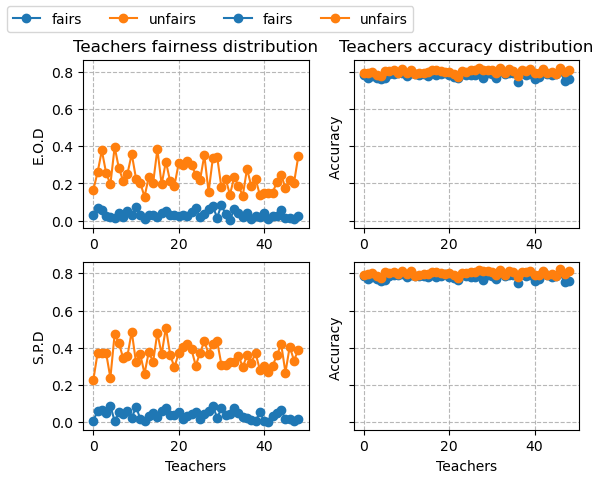

In [18]:
import matplotlib.pyplot as plt
fairs = []
ufairs = []
f_acc, f_rec = [], []
uf_acc, uf_rec = [], []

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharey=True)
for st in states:
    with open("../checkpoint_sex/" + st + "/"+ st + "_fair.pkl", "rb") as f:
        tchr = pickle.load(f)
    fairs.append(tchr.metrics["EOD"])
    f_acc.append(tchr.metrics["ACC"])
    f_rec.append(tchr.metrics["REC"])
    with open("../checkpoint_sex/" + st + "/"+ st + "_unfair.pkl", "rb") as f:
        tchr = pickle.load(f)
    ufairs.append(tchr.metrics["EOD"])
    uf_acc.append(tchr.metrics["ACC"])
    uf_rec.append(tchr.metrics["REC"])
ax1.plot(list(range(len(states))), fairs, label="fairs", marker='o')
ax1.plot(list(range(len(states))), ufairs, label="unfairs", marker='o')
ax2.plot(list(range(len(states))), f_acc, marker='o')
ax2.plot(list(range(len(states))), uf_acc, marker='o')
ax1.set_ylabel("E.O.D")
ax1.set_title("Teachers fairness distribution")
ax2.set_ylabel("Accuracy ")
ax2.set_title("Teachers accuracy distribution")

fairs = []
ufairs = []
f_acc, f_rec = [], []
uf_acc, uf_rec = [], []

for st in states:
    with open("../checkpoint_sex/" + st + "/"+ st + "_fair.pkl", "rb") as f:
        tchr = pickle.load(f)
    fairs.append(tchr.metrics["SPD"])
    f_acc.append(tchr.metrics["ACC"])
    f_rec.append(tchr.metrics["REC"])
    with open("../checkpoint_sex/" + st + "/"+ st + "_unfair.pkl", "rb") as f:
        tchr = pickle.load(f)
    ufairs.append(tchr.metrics["SPD"])
    uf_acc.append(tchr.metrics["ACC"])
    uf_rec.append(tchr.metrics["REC"])
ax3.plot(list(range(len(states))), fairs, label="fairs", marker='o')
ax3.plot(list(range(len(states))), ufairs, label="unfairs", marker='o')
ax4.plot(list(range(len(states))), f_acc, marker='o')
ax4.plot(list(range(len(states))), uf_acc, marker='o')
ax3.set_xlabel("Teachers")
ax3.set_ylabel("S.P.D")
ax4.set_ylabel("Accuracy ")
ax4.set_xlabel("Teachers")

ax1.grid(True, linestyle='--', alpha=0.9)
ax2.grid(True, linestyle='--', alpha=0.9)
ax3.grid(True, linestyle='--', alpha=0.9)
ax4.grid(True, linestyle='--', alpha=0.9)

fig.legend(loc="outside upper left", ncol=4)
plt.savefig("../img/acsemployment_teachers_stats.png")
plt.show()

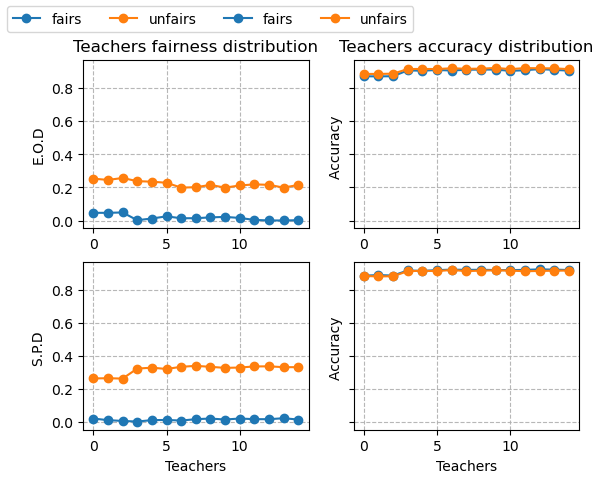

In [19]:
fairs = []
ufairs = []
f_acc, f_rec = [], []
uf_acc, uf_rec = [], []

class AdultTeacher():
    """
        Define teachers' structure
    """
    def __init__(self, model, metrics):
        self.metrics = metrics
        self.model = model

eod_fairs_path = "../checkpoint_adult/EOD/fairs/models.pkl"
eod_unfairs_path = "../checkpoint_adult/EOD/unfairs/models.pkl"
spd_fairs_path = "../checkpoint_adult/SPD/fairs/models.pkl"
spd_unfairs_path = "../checkpoint_adult/SPD/unfairs/models.pkl"

with open(eod_fairs_path, "rb") as f:
    eod_fairs = pickle.load(f)
with open(eod_unfairs_path, "rb") as f:
    eod_unfairs = pickle.load(f)
with open(spd_fairs_path, "rb") as f:
    spd_fairs = pickle.load(f)
with open(spd_unfairs_path, "rb") as f:
    spd_unfairs = pickle.load(f)
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharey=True)
for tchr in eod_fairs:
    f_acc.append(tchr.metrics["ACC"])
    fairs.append(tchr.metrics["EOD"])
    
for tchr in eod_unfairs:
    uf_acc.append(tchr.metrics["ACC"])
    ufairs.append(tchr.metrics["EOD"])

#plt.yticks([i for i in np.arange(0, 1, 0.05)])
ax1.plot(list(range(len(fairs))), fairs, label="fairs", marker='o')
ax1.plot(list(range(len(ufairs))), ufairs, label="unfairs", marker='o')
ax2.plot(list(range(len(f_acc))), f_acc, marker='o')
ax2.plot(list(range(len(uf_acc))), uf_acc, marker='o')
ax1.set_ylabel("E.O.D")
ax1.set_title("Teachers fairness distribution")
ax2.set_ylabel("Accuracy ")
ax2.set_title("Teachers accuracy distribution")

fairs = []
ufairs = []
f_acc, f_rec = [], []
uf_acc, uf_rec = [], []
for tchr in spd_fairs:
    f_acc.append(tchr.metrics["ACC"])
    fairs.append(tchr.metrics["SPD"])
    
for tchr in spd_unfairs:
    uf_acc.append(tchr.metrics["ACC"])
    ufairs.append(tchr.metrics["SPD"])

ax3.plot(list(range(len(fairs))), fairs, label="fairs", marker='o')
ax3.plot(list(range(len(ufairs))), ufairs, label="unfairs", marker='o')
ax4.plot(list(range(len(f_acc))), f_acc, marker='o')
ax4.plot(list(range(len(uf_acc))), uf_acc, marker='o')
ax3.set_xlabel("Teachers")
ax3.set_ylabel("S.P.D ")
ax4.set_ylabel("Accuracy ")
ax4.set_xlabel("Teachers")

ax1.grid(True, linestyle='--', alpha=0.9)
ax2.grid(True, linestyle='--', alpha=0.9)
ax3.grid(True, linestyle='--', alpha=0.9)
ax4.grid(True, linestyle='--', alpha=0.9)

fig.legend(loc="outside upper left", ncol=4)
plt.savefig("../img/adult_teachers_stats.png")
plt.show()

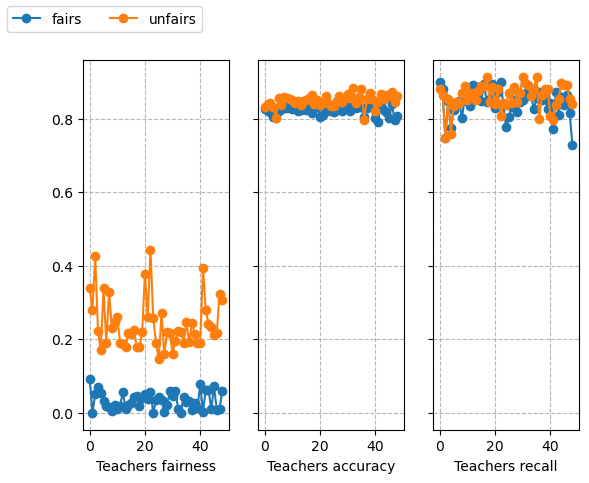

In [20]:
import matplotlib.pyplot as plt
fairs = []
ufairs = []
f_acc, f_rec = [], []
uf_acc, uf_rec = [], []

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,sharey=True)
for st in states:
    with open("../checkpoint_race/" + st + "/"+ st + "_fair.pkl", "rb") as f:
        tchr = pickle.load(f)
    fairs.append(tchr.metrics["EOD"])
    f_acc.append(tchr.metrics["ACC"])
    f_rec.append(tchr.metrics["REC"])
    with open("../checkpoint_race/" + st + "/"+ st + "_unfair.pkl", "rb") as f:
        tchr = pickle.load(f)
    ufairs.append(tchr.metrics["EOD"])
    uf_acc.append(tchr.metrics["ACC"])
    uf_rec.append(tchr.metrics["REC"])
ax1.plot(list(range(len(states))), fairs, label="fairs", marker='o')
ax1.plot(list(range(len(states))), ufairs, label="unfairs", marker='o')
ax2.plot(list(range(len(states))), f_acc, marker='o')
ax2.plot(list(range(len(states))), uf_acc, marker='o')
ax3.plot(list(range(len(states))), f_rec, marker='o')
ax3.plot(list(range(len(states))), uf_rec, marker='o')
ax1.set_xlabel("Teachers fairness")
ax2.set_xlabel("Teachers accuracy")
ax3.set_xlabel("Teachers recall")

ax1.grid(True, linestyle='--', alpha=0.9)
ax2.grid(True, linestyle='--', alpha=0.9)
ax3.grid(True, linestyle='--', alpha=0.9)

fig.legend(loc="outside upper left", ncol=2)
plt.show()

# Student stats

In [5]:
import sys
sys.path.append("../src")

In [6]:
from student import *
from aggregator import *
from teacher_ensemble import *

In [7]:
(x_train, x_test, y_train, y_test, s_train, s_test) = load_student_data("AK")

In [8]:
conf = ["All", "Only fair", "Only unfair", "WV0", "Fairfed", "WV1", "WV2"]
def get_agg(cf):
    if cf == "All":
        aggregator = plurality
    elif cf == "Only fair":
        aggregator = only_fair
    elif cf == "Only unfair":
        aggregator = only_unfair
    elif cf == "WV0":
        aggregator = weighed_vote
    elif cf == "Fairfed":
        aggregator = fair_fed_agg
    elif cf == "WV1":
        aggregator = wv1_aggregator
    elif cf == "WV2":
        aggregator = wv2_aggregator
    
    return aggregator

In [9]:
def training_student(nb_teachers, nb_fair_tchrs):
    rec_acc = {}
    for cf in conf:
        rec_acc[cf] = []

    tchrs_ensemble = Ensemble(nb_teachers, nb_fair_tchrs)
    update_teachers(tchrs_ensemble.tchrs)

    eod = []
    for tchrs in tchrs_ensemble.tchrs:
        eod.append(tchrs.metrics["EOD"])
    set_metrics(eod)

    for cf in conf:
        print(f"methode : {cf}")
        aggregator = get_agg(cf)
        y_train, _ = aggregator(x_train)
        yhat_test, _ = aggregator(x_test)
        st_model = train_student(x_train, y_train, verbose=False)
        st_stats = fairness(st_model, x_test, yhat_test, s_test, y_test)
        rec_acc[cf].append(st_stats["ACC"])
        rec_acc[cf].append(st_stats["REC"])
        rec_acc[cf].append(st_stats["ACC_TL"])
        rec_acc[cf].append(st_stats["REC_TL"])
    return rec_acc

In [10]:
rec_acc = training_student(30, randint(1,30))

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step
184/184 ━━━━━━━━━━━━━━━━━━━━ 0

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 813us

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.9498 - loss: 0.1304 - recall: 0.9375
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.7046 - loss: 2.2031 - recall: 0.7587
methode : Fairfed
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
127/1

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
32/32 ━━━━━━

In [22]:
rec_acc

{'All': [0.9506, 0.9607, 0.7095, 0.7905],
 'Only fair': [0.9595, 0.9681, 0.7134, 0.8069],
 'Only unfair': [0.9358, 0.9587, 0.7105, 0.7577],
 'WV0': [0.9476, 0.9355, 0.7233, 0.7851],
 'Fairfed': [0.916, 0.9269, 0.7075, 0.7869],
 'WV1': [0.9585, 0.9439, 0.7283, 0.8069],
 'WV2': [0.9585, 0.976, 0.7125, 0.816]}

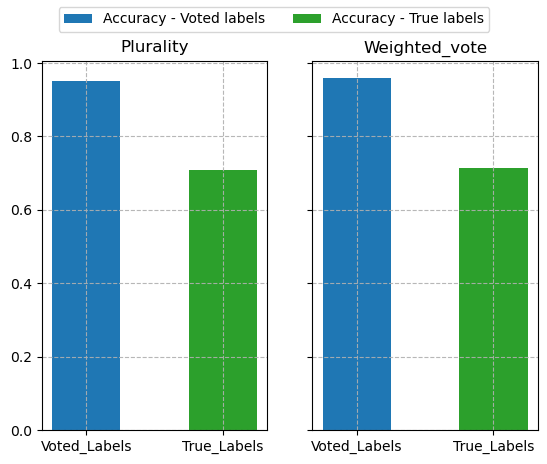

In [17]:
import matplotlib.pyplot as plt
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#axes[1][3].set_visible(False)
ax1.set_title("Plurality")
ax2.set_title("Weighted_vote")

l = 0
i = 0
b_width = 0.5
x_axes = [1, 2]
for cf in conf:
    if cf == "All":
        lab = "Plurality"
    elif cf == "WV2":
        lab = "Weigh_vote_2"
    else:
        continue
    if l < 1:
        ax.set_title(lab)
    else:
        ax.set_xlabel(lab)
    acc, _, acc_tl, _ = rec_acc[cf]
    if cf == "All":
        ax1.bar([x_axes[0]], [acc], width = b_width, color = colors[0], label="Accuracy - Voted labels")
        ax1.bar([x_axes[1]], [acc_tl], width = b_width, color = colors[2], label="Accuracy - True labels")
    else:
        ax2.bar([x_axes[0]], [acc], width = b_width, color = colors[0])
        ax2.bar([x_axes[1]], [acc_tl], width = b_width, color = colors[2])

ax1.set_xticks([1, 2], ["Voted_Labels", "True_Labels"])
ax1.grid(True, linestyle='--', alpha=0.9)


ax2.set_xticks([1, 2], ["Voted_Labels", "True_Labels"])
ax2.grid(True, linestyle='--', alpha=0.9)

fig.legend(loc="outside upper center", ncol=4)
plt.savefig("../img/st_acc_acsemployment.png")
plt.show()

# Training student without PATE - EOD with/others

In [20]:
(x_train, x_test, y_train, y_test, s_train, s_test) = load_student_data("AK", alpha=[100,30])
st_model = train_student(x_train, y_train, verbose=False)
stats = fairness(st_model, x_test, y_test, s_test)
stats

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8137 - loss: 0.5592 - recall: 0.7572
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


{'EOD': 0.0979,
 'SPD': 0.3843,
 'ACC': 0.8064,
 'REC': 0.7615,
 'ACC_TL': '-',
 'REC_TL': '-'}

In [19]:
x_train

array([[70.,  5.,  1., ...,  2.,  2.,  4.],
       [50., 16.,  5., ...,  2.,  1.,  5.],
       [48., 21.,  1., ...,  2.,  2.,  1.],
       ...,
       [28., 21.,  1., ...,  2.,  1.,  2.],
       [53., 13.,  3., ...,  2.,  1.,  4.],
       [32., 14.,  5., ...,  2.,  1.,  4.]])

In [33]:
# ubalance student dataset
(x_train, x_test, y_train, y_test, s_train, s_test) = load_student_data("AK", alp)
st_model = train_student(x_train, y_train, verbose=False)
stats = fairness(st_model, x_test, y_test, s_test)
stats

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.8393 - loss: 0.4077 - recall: 0.7891
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


{'EOD': 0.0394,
 'SPD': 0.1064,
 'ACC': 0.8042,
 'REC': 0.7545,
 'ACC_TL': '-',
 'REC_TL': '-'}

# Train student without PATE - EOD with/black

In [186]:
data_src = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_src.get_data(states=["AK"], download=True)
features, labels, group = ACSEmployment.df_to_numpy(acs_data)
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
    features, labels, group, test_size=0.2, random_state=0
)
st_model = train_student(x_train, y_train, verbose=False)
stats = fairness(st_model, x_test, y_test, s_test)
stats

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.8174 - loss: 0.4005 - recall: 0.8015


{'EOD': 0.2813,
 'SPD': 0.1883,
 'ACC': 0.7937,
 'REC': 0.7688,
 'ACC_TL': '-',
 'REC_TL': '-'}

In [31]:
(x_train, x_test, y_train, y_test, s_train, s_test) = load_unb_student_data("AK")
st_model = train_student(x_train, y_train, verbose=False)
stats = fairness(st_model, x_test, y_test, s_test)
stats

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8393 - loss: 0.4077 - recall: 0.7891  
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


{'EOD': 0.0394,
 'SPD': 0.1064,
 'ACC': 0.8042,
 'REC': 0.7545,
 'ACC_TL': '-',
 'REC_TL': '-'}

# Data distributions
### Teachers


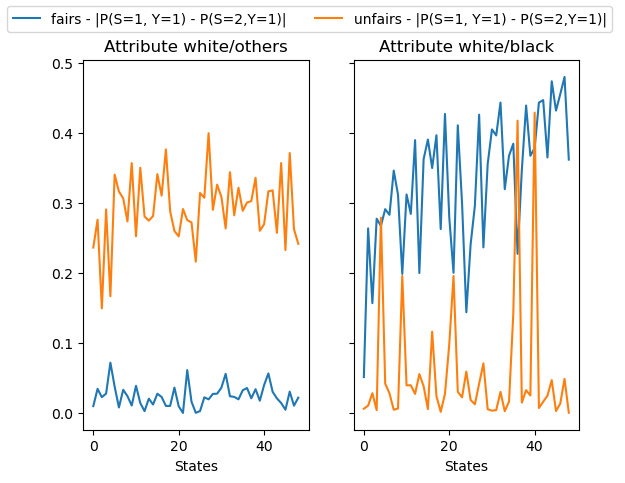

In [27]:
import matplotlib.pyplot as plt
def model_disp(tpe, st, fair=True):
    if tpe == 1:
        root = "../checkpoint_sex/"
    else:
        root = "../checkpoint_race/"
    f = ""
    if not fair:
        f = "un"
    path = root + st + "/" + st + "_" + f + "fair.pkl"
    with open(path, "rb") as f:
        tchr = pickle.load(f)
    x_train, x_test, y_train, y_test, g_train, g_test = tchr.splited_data
    if  not isinstance(x_train, pd.DataFrame):
        x_train = pd.DataFrame(x_train, columns=ACSEmployment.features)
    x_train.insert(0, ACSEmployment.target, y_train)
    if tpe == 1:
        sts = x_train[["SEX", ACSEmployment.target]].value_counts(normalize=True)
    else:
        sts = x_train[[ACSEmployment.group, ACSEmployment.target]].value_counts(normalize=True)
    return abs(sts[1][True] - sts[2][True])
    
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
f_model1_disp = []
uf_model1_disp = []
f_model2_disp = []
uf_model2_disp = []

for st in states:
    f_model1_disp.append(model_disp(1, st))
    uf_model1_disp.append(model_disp(1, st, False))
    
    f_model2_disp.append(model_disp(0, st))
    uf_model2_disp.append(model_disp(0, st, False))
    

ax1.set_title("Attribute white/others")
ax2.set_title("Attribute white/black")
x_axis = list(range(len(states)))
ax1.plot(x_axis, f_model1_disp, label="fairs - |P(S=1, Y=1) - P(S=2,Y=1)|")
ax1.plot(x_axis, uf_model1_disp, label="unfairs - |P(S=1, Y=1) - P(S=2,Y=1)|")
ax2.plot(x_axis, f_model2_disp)
ax2.plot(x_axis, uf_model2_disp)
ax1.set_xlabel("States")
ax2.set_xlabel("States")
fig.legend(loc="outside upper left", ncol=3)
plt.show()

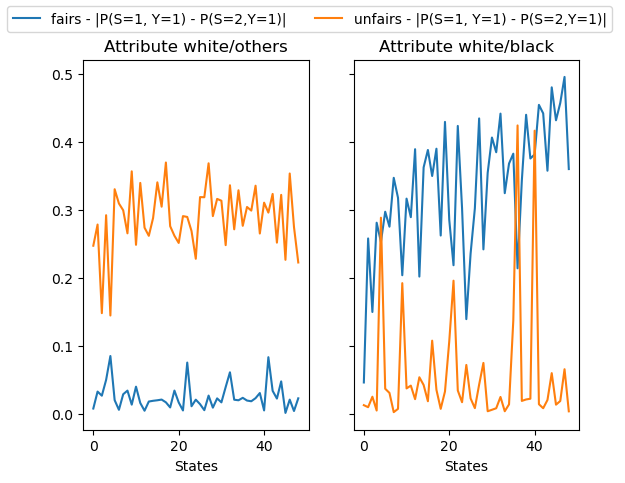

In [29]:
import matplotlib.pyplot as plt
def model_disp(tpe, st, fair=True):
    if tpe == 1:
        root = "../checkpoint_sex/"
    else:
        root = "../checkpoint_race/"
    f = ""
    if not fair:
        f = "un"
    path = root + st + "/" + st + "_" + f + "fair.pkl"
    with open(path, "rb") as f:
        tchr = pickle.load(f)
    x_train, x_test, y_train, y_test, g_train, g_test = tchr.splited_data
    if  not isinstance(x_test, pd.DataFrame):
        x_test = pd.DataFrame(x_test, columns=ACSEmployment.features)
    x_test.insert(0, ACSEmployment.target, y_test)
    if tpe == 1:
        sts = x_test[["SEX", ACSEmployment.target]].value_counts(normalize=True)
    else:
        sts = x_test[[ACSEmployment.group, ACSEmployment.target]].value_counts(normalize=True)
    return abs(sts[1][True] - sts[2][True])
    
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
f_model1_disp = []
uf_model1_disp = []
f_model2_disp = []
uf_model2_disp = []

for st in states:
    f_model1_disp.append(model_disp(1, st))
    uf_model1_disp.append(model_disp(1, st, False))
    
    f_model2_disp.append(model_disp(0, st))
    uf_model2_disp.append(model_disp(0, st, False))
    

ax1.set_title("Attribute white/others")
ax2.set_title("Attribute white/black")
x_axis = list(range(len(states)))
ax1.plot(x_axis, f_model1_disp, label="fairs - |P(S=1, Y=1) - P(S=2,Y=1)|")
ax1.plot(x_axis, uf_model1_disp, label="unfairs - |P(S=1, Y=1) - P(S=2,Y=1)|")
ax2.plot(x_axis, f_model2_disp)
ax2.plot(x_axis, uf_model2_disp)
ax1.set_xlabel("States")
ax2.set_xlabel("States")
fig.legend(loc="outside upper left", ncol=3)
plt.show()